<a href="https://colab.research.google.com/github/soseongha/CicC-Calories_intake_consumption_Caculator/blob/main/Calorie_Calculator_final_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/calories

/content/drive/MyDrive/calories


## <1> 회귀

In [ ]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.linear_model import Ridge,Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import f1_score

### 1. 랜덤시드 고정
매 실행마다 값이 같게 나오도록 함

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(19) # Seed 고정

In [ ]:
cal = pd.read_csv('calories.csv')
exercise = pd.read_csv('exercise.csv')

### 2. 칼로리양 + 운동량 데이터 합치기
userID를 key로 두가지를 합친다

In [ ]:
train = pd.concat([exercise, cal['Calories']], axis=1)

### 3. EDA

#### 3-1. describe로 알 수 있는 점</br>
(1) userID는 학습에 포함시키지 않아야 한다.</br>
(2) 운동 시간 (duration) 은 30분이 최대값이다.</br>
(3) temperature의 중앙값이 섭씨 40도이다.

</br> **결론 : minmax scaling을 해야 한다.**











































In [ ]:
train.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [ ]:
train = train.drop('User_ID',axis=1)

#### 3-2. 산점도로 알 수 있는 것
-> 선형이 아니다. polynomial regression으로 접근.

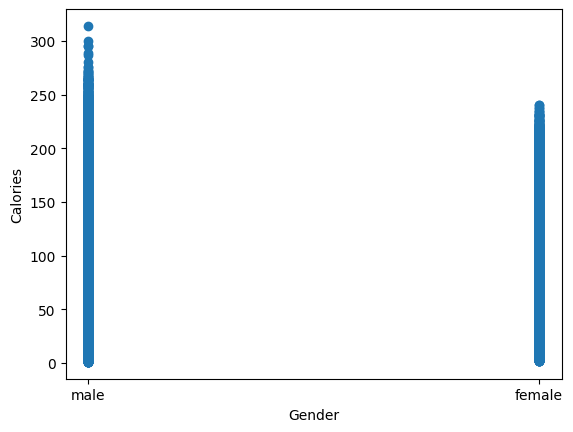

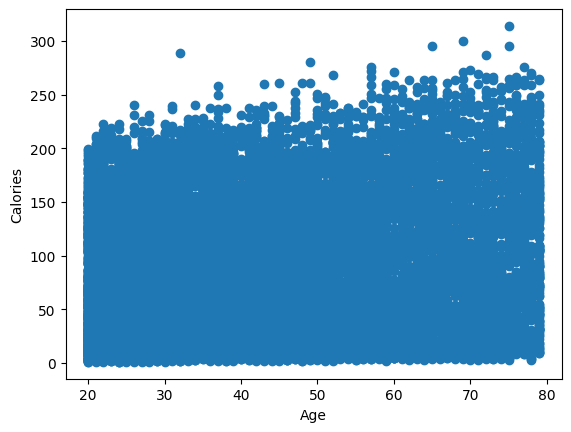

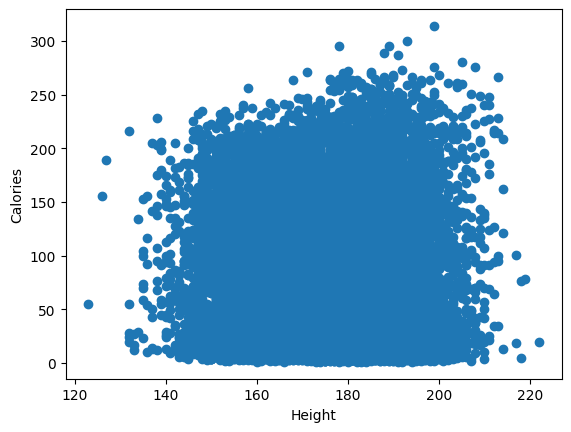

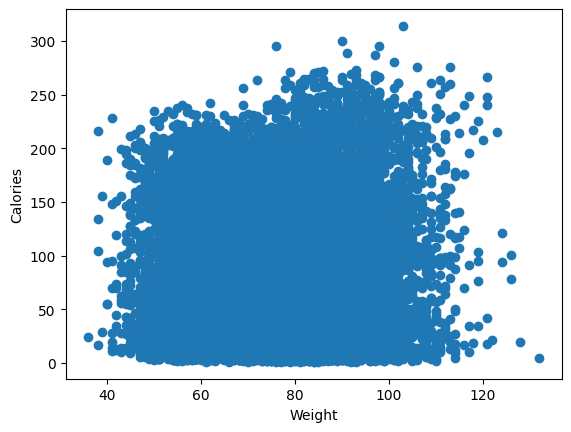

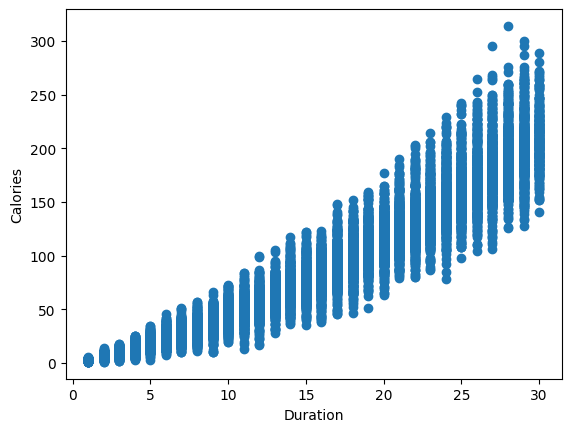

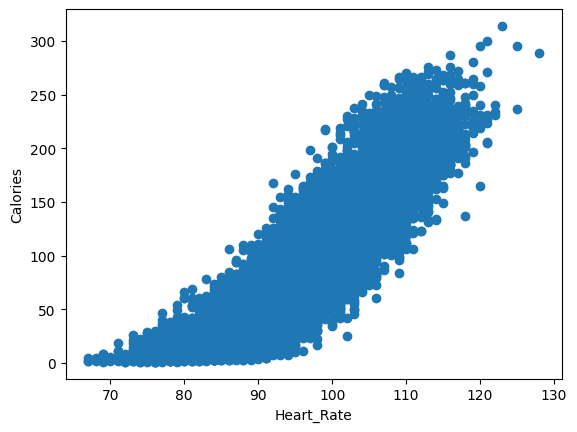

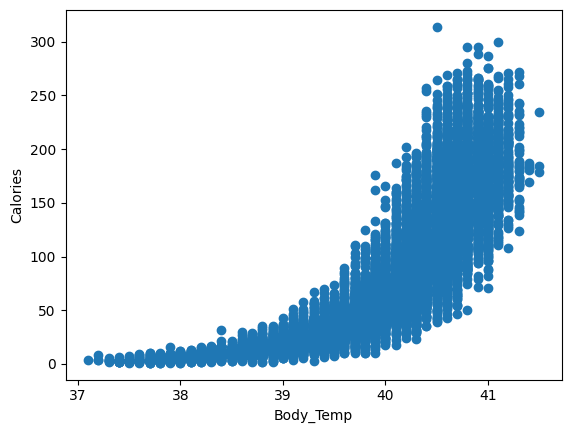

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

target = 'Calories'

for feature in train.columns:
  if feature != target:
    plt.scatter(train[feature], train[target])
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

### 4. IQR 이상치 제거

In [ ]:
# z-score로 이상치 유무 판단
threshold = 2

numerical_cols = ['Age','Height','Weight','Duration','Heart_Rate','Body_Temp']

for feature in numerical_cols:
  z_scores = (train[feature] - train[feature].mean()) / train[feature].std()
  print(feature, z_scores)

Age 0        1.484677
1       -1.342135
2        1.543568
3       -0.517648
4       -0.929891
           ...   
14995   -1.342135
14996   -0.929891
14997    0.012379
14998    2.073596
14999    1.190217
Name: Age, Length: 15000, dtype: float64
Height 0        1.089546
1       -0.593706
2        0.318055
3        0.318055
4       -1.435332
           ...   
14995    1.299952
14996   -0.663842
14997   -1.084655
14998    1.299952
14999   -0.102758
Name: Height, Length: 15000, dtype: float64
Weight 0        1.265866
1       -0.995425
2        0.268238
3       -0.263831
4       -1.128442
           ...   
14995    0.733798
14996   -0.662882
14997   -1.128442
14998    1.465392
14999    0.268238
Name: Weight, Length: 15000, dtype: float64
Duration 0        1.619073
1       -0.183984
2       -1.265818
3       -0.304188
4       -0.664799
           ...   
14995   -0.544595
14996   -1.145615
14997    0.056424
14998   -1.626430
14999    0.296831
Name: Duration, Length: 15000, dtype: float64
Heart_

In [ ]:
'''def remove_outliers_IQR(data, threshold=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]'''

'def remove_outliers_IQR(data, threshold=1.5):\n    Q1 = np.percentile(data, 25)\n    Q3 = np.percentile(data, 75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - threshold * IQR\n    upper_bound = Q3 + threshold * IQR\n    return data[(data >= lower_bound) & (data <= upper_bound)]'

In [ ]:
'''remove_outliers_IQR(exercise)'''

'remove_outliers_IQR(exercise)'

### 5. one hot encoding
categorical인 Gender feature에 대해서 원핫인코딩을 진행한다.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, drop='first')

gender_encoded = train['Gender'].values.reshape(-1, 1)

gender_encoded = encoder.fit_transform(gender_encoded)

In [ ]:
train.drop('Gender', axis=1, inplace=True)

gender_encoded_df = pd.DataFrame(gender_encoded, columns=['Gender'])

train = pd.concat([train, gender_encoded_df], axis=1)

In [ ]:
train.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Gender
0,68,190.0,94.0,29.0,105.0,40.8,231.0,1.0
1,20,166.0,60.0,14.0,94.0,40.3,66.0,0.0
2,69,179.0,79.0,5.0,88.0,38.7,26.0,1.0
3,34,179.0,71.0,13.0,100.0,40.5,71.0,0.0
4,27,154.0,58.0,10.0,81.0,39.8,35.0,0.0


### 6. minmax scaler
3에서 알아낸 것을 바탕으로 minmax scaling을 한다. (0~1사이의 값으로 정규화)




In [ ]:
from sklearn.preprocessing import MinMaxScaler
numerical_cols = ['Age','Height','Weight','Duration','Heart_Rate','Body_Temp']

minmax_scaler = MinMaxScaler()
train[numerical_cols] = minmax_scaler.fit_transform(train[numerical_cols])

### 7. train test split
15000개의 데이터를 train test split으로 train data/validation data/test data로 나눈다.

In [ ]:
from sklearn.model_selection import train_test_split

X = train.drop('Calories', axis=1) # target feature가 Status(대출의 승인 여부)
y = train['Calories']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9)

### 8. regression
3에서 알아낸 것을 바탕으로 다항회귀 진행

In [ ]:
# 다항회귀
from sklearn.preprocessing import PolynomialFeatures

#### 최적의 하이퍼파라미터(학습율과 차수)를 구하기 위한 grid search

In [ ]:
degree=[3,5,7]

param = {'alpha': [0.0001,0.001,0.1]}

best_degree = None
best_score = -np.inf
best_alpha = None

for degree in degree:
  polynomial_features = PolynomialFeatures(degree=degree)
  X_poly_train = polynomial_features.fit_transform(X_train)
  X_poly_val = polynomial_features.transform(X_val)

  grid_search = GridSearchCV(estimator=Ridge(), param_grid=param, cv=5)
  grid_search.fit(X_train, y_train)

  alpha = grid_search.best_params_['alpha']

  model = Ridge(alpha)
  model.fit(X_poly_train,y_train)
  score = model.score(X_poly_val,y_val)

  if score > best_score:
    best_score = score
    best_degree = degree
    best_alpha = alpha

print("최적의 차수: ", best_degree)
print("최적의 학습율: ", best_alpha)

최적의 차수:  3
최적의 학습율:  0.001


#### 최적의 차수와 학습율을 적용해 다항회귀

In [ ]:
polynomial_features = PolynomialFeatures(degree=best_degree)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

#### 다항회귀한 것을 바탕으로 한번 더 릿지 규제 적용

In [ ]:
ridge_regression = Ridge()
ridge_regression.fit(X_train_poly,y_train)

coefficients = ridge_regression.coef_

#### 다항회귀 + 릿지규제 모델 학습

In [ ]:
model_reg = Ridge(best_alpha)
model_reg.coef_ = coefficients
model_reg.fit(X_train_poly,y_train)

Ridge(alpha=0.001)

In [ ]:
X_train.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Gender
10541,0.118644,0.343434,0.166667,0.862069,0.622951,0.863636,0.0
2839,0.559322,0.717172,0.604167,0.344828,0.442623,0.659091,1.0
9180,0.745763,0.676768,0.572917,0.344828,0.360656,0.636364,1.0
3380,0.118644,0.444444,0.250000,0.931034,0.557377,0.863636,0.0
4372,0.406780,0.606061,0.531250,0.896552,0.606557,0.818182,1.0


### 9. cross validation

In [ ]:
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold
#from sklearn.metrics import mean_squared_error

In [ ]:
#X = X_train.columns
#y = target

#score = cross_val_score(model, X, y, scoring = 'accuracy', cv=5)
#print(f"단일 accuracy : {score}")
#print(f"평균 accuracy: {np.mean(score)}")

### 10. Test

#### 예측

In [ ]:
y_pred= model_reg.predict(X_test_poly)
y_pred = np.round(y_pred).astype(int)

y_pred

array([ 63,  73,   7, ..., 123, 119,  88])

In [ ]:
len(y_pred)

1500

#### 결과

In [ ]:
fl = f1_score(y_pred, y_test, average="macro")
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mse)

In [ ]:
print("f1 : ", fl)
print("mse : ",mse)
print("R2 : ",r2)
print("rmse : ",rmse)

f1 :  0.9741064453222421
mse :  0.018
R2 :  0.9999952694190875
rmse :  0.1341640786499874


## <2> OCR

### 이미지 불러오기 함수

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#같은 드라이브에서 이미지 불러오는 함수
def get_image(image_path:str):

    resize_impath = _kakao_ocr_resize(image_path)
    if resize_impath is not None:
        image_path = resize_impath

    img=cv2.imread(image_path, cv2.IMREAD_COLOR)
    file= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cv2_imshow(img)


### 이미지 전처리 및 카카오 OCR 사용 함수

In [ ]:
#Kakao OCR api
import json

import requests
import sys

LIMIT_PX = 1024
LIMIT_BYTE = 1024*1024  # 1MB
LIMIT_BOX = 40


def _kakao_ocr_resize(image_path: str):
    """
    ocr detect/recognize api helper
    ocr api의 제약사항이 넘어서는 이미지는 요청 이전에 전처리가 필요.

    pixel 제약사항 초과: resize
    용량 제약사항 초과  : 다른 포맷으로 압축, 이미지 분할 등의 처리 필요. (처리X)

    :param image_path: 이미지파일 경로
    :return:
    """
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    if LIMIT_PX < height or LIMIT_PX < width:
        ratio = float(LIMIT_PX) / max(height, width)
        image = cv2.resize(image, None, fx=ratio, fy=ratio)
        height, width, _ = height, width, _ = image.shape

        # api 사용전에 이미지가 resize된 경우, recognize시 resize된 결과를 사용해야함.
        image_path = "{}_resized.jpg".format(image_path)
        cv2.imwrite(image_path, image)

        return image_path
    return None

In [ ]:
def _kakao_ocr(image_path: str, appkey: str):
    """
    OCR api request example
    :param image_path: 이미지파일 경로
    :param appkey: 카카오 앱 REST API 키
    """
    API_URL = 'https://dapi.kakao.com/v2/vision/text/ocr'

    headers = {'Authorization': 'KakaoAK {}'.format(appkey)}

    image = cv2.imread(image_path)
    jpeg_image = cv2.imencode(".jpg", image)[1]
    data = jpeg_image.tobytes()


    return requests.post(API_URL, headers=headers, files={"image": data})

In [ ]:
def get_orc_json(image_path: str, appkey: str):
    """
    Get orc outputdata for json
    :param image_path: 이미지파일 경로
    :param appkey: 카카오 앱 REST API 키
    """

    if len(sys.argv) != 3:
        print("Please run with args: $ python example.py /path/to/image appkey")

    resize_impath = _kakao_ocr_resize(image_path)
    if resize_impath is not None:
        image_path = resize_impath
        print("원본 대신 리사이즈된 이미지를 사용합니다.")

    #카카오 API에서 범위, 인식한 글씨 받기
    output = _kakao_ocr(image_path, appkey).json()
    outputdata = json.dumps(output, ensure_ascii=False,sort_keys=True, indent=2)
    #print("[OCR] output:\n{}\n".format(outputdata))

    #받은 데이터 array로 변환
    outputdata = json.loads(outputdata)

    return outputdata

### list match 함수

In [ ]:
def find_kcal_in_output(output: list, image_path: str):
    """
    Find kcal number in output, output에서 kcal 앞의 숫자를 찾기
    :otuput: json.loads()의 결과
    """
    search = "kcal"

    resize_impath = _kakao_ocr_resize(image_path)
    if resize_impath is not None:
        image_path = resize_impath

    for i in range(len(output['result'])):

      line = output['result'][i]['recognition_words'][0]
      result = line.find(search)

      #ocr의 판독결과에서 kcal가 들어간 부분이라면 이 앞 글자들을 리턴
      if (result != -1):

        ret = line[0:result]

        #만약 kcal 글자가 있으나 숫자와 따로 저장되었다면
        #바로 앞의 box에서도 결과 가져오기
        if(line[0:result] == ""):

            #box 모양으로 잘라서 보여주기
            x = output['result'][i-1]['boxes'][0][0]
            y = output['result'][i-1]['boxes'][0][1]
            w =  (output['result'][i-1]['boxes'][1][0] -  output['result'][i-1]['boxes'][0][0])
            h =  (output['result'][i-1]['boxes'][2][1] -  output['result'][i-1]['boxes'][0][1])
            #원본 이미지
            org_image = cv2.imread(image_path)
            #자른 이미지
            img_trim = org_image[y:y+h, x:x+w]
            #자른 이미지 보여주기
            cv2_imshow(img_trim)

            print(output['result'][i-1]['recognition_words'][0])

            ret = output['result'][i-1]['recognition_words'][0]

        #box 모양으로 잘라서 보여주기
        x = output['result'][i]['boxes'][0][0]
        y = output['result'][i]['boxes'][0][1]
        w =  (output['result'][i]['boxes'][1][0] -  output['result'][i]['boxes'][0][0])
        h =  (output['result'][i]['boxes'][2][1] -  output['result'][i]['boxes'][0][1])
        #원본 이미지
        org_image = cv2.imread(image_path)
        #자른 이미지
        img_trim = org_image[y:y+h, x:x+w]
        #자른 이미지 보여주기
        cv2_imshow(img_trim)
        print(output['result'][i]['recognition_words'][0])

        #kcal 앞 글자를 리턴
        return ret

    return ""

## <3> 음식 칼로리 크롤링

In [ ]:
import requests
from bs4 import BeautifulSoup

### 링크 프로세싱

In [ ]:
def name_to_link(food_name:str):
  """
  processing food_name to link available to crawling
  음식 이름을 포함해서 크롤링을 위한 input link에서 쓰이는 포맷으로 변환

  :param food_name: 이미지 인식의 예측 결과로 나온 음식 이름 label string
  :return: 정상적으로 작동하지 않았을 경우 -1 리턴, 아니면 음식 이름을 포함한 타겟 링크 string
  """

  if not food_name:
    return -1;

  food_new = food_name.replace(' ','%20')
  link = "https://www.fatsecret.com/calories-nutrition/search?q=" + food_new
  return link

#print(name_to_link("apple pie"))

### 크롤러 정의

In [ ]:
def crawling_calorie(food_name:str):
  """
  crawling_calorie number from web site using food_name
  food_name을 통해 웹사이트로부터 이름에 매칭하는 칼로리 값을 가져오는 함수

  :param food_name: 이미지 인식의 예측 결과로 나온 음식 이름 label string
  :return: 음식 이름과 가장 가까운 검색어와 음식 이름에 매칭되는 칼로리 값
  """

  link = name_to_link(food_name)

  # food_name이 비었거나 비정상적으로 변환됨
  if link == -1:
    return -1, -1

  headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36'}
  data = requests.get(link,headers=headers)
  soup = BeautifulSoup(data.text, 'html.parser')

  s_food_name  = soup.select_one('.searchResult td .prominent').text

  link = soup.select_one('.searchResult td .smallText.greyText.greyLink')
  text = link.text
  start = text.find('Calories: ') + len('Calories: ')
  calorie = text[start:].split('kcal')[0]

  # Calories 글자를 찾지 못하였으므로 에러 발생
  if calorie == '':
    return -2, -2

  return s_food_name, calorie

#crawling_calorie('apple pie')

## <4> 음식 이미지 분류 모델

### 파일 압축 풀기

In [ ]:
# 파일 압축 풀기
!unzip -qq "/content/drive/MyDrive/calories/archive.zip"

### 라이브러리 선언

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
!pip install split-folders timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, optim
import timm # 진행상황 시각화
import torchvision
from torchvision import datasets, transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
import splitfolders #한 폴더 쏙 데이터들을 /train, /val, /test로 나눠주는 라이브러리

In [ ]:
torchvision.__version__, torch.__version__

('0.15.2+cu118', '2.0.1+cu118')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### 데이터 가져오기

In [ ]:
origin_path = "/content/drive/MyDrive/calories/images" # 원래 이미지들 폴더
new_path = '/content/drive/MyDrive/calories/new_images/' # /train, /val, /test로 분류된 새 이미지들 폴더

In [ ]:
# 새로운 폴더 만들기
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder(new_path)

In [ ]:
# 새 폴더에 이미지 비율만큼 나누어서 분류하여 저장
splitfolders.ratio(origin_path, output=new_path, seed=133, ratio=(0.7,0.15,0.15)) # train : val : test = 7 : 1.5 : 1.5 비율

Copying files: 101000 files [19:19, 87.12 files/s] 


In [ ]:
# normalization을 위해 평균과 표준편차 계산하기
import tensorflow as tf
def get_mean_std(data_dir):
    '''
    이미지 정규화 시 성능 향상 , 평균과 표준편차로 정규화 실행
    data_dir = 이미지 들어있는 폴더 path
    '''
    with tf.device('/gpu:0'):

      transform = transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor()
      ])

      dataset = datasets.ImageFolder(data_dir, transform)
      print("데이터 정보", dataset)

      meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in dataset]
      stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in dataset]

      meanR = np.mean([m[0] for m in meanRGB])
      meanG = np.mean([m[1] for m in meanRGB])
      meanB = np.mean([m[2] for m in meanRGB])

      stdR = np.mean([s[0] for s in stdRGB])
      stdG = np.mean([s[1] for s in stdRGB])
      stdB = np.mean([s[2] for s in stdRGB])
      print("평균",meanR, meanG, meanB)
      print("표준편차",stdR, stdG, stdB)

# train data, test data를 각각 normalization
get_mean_std(os.path.join(new_path, "train/"))
get_mean_std(os.path.join(new_path, "val/"))
get_mean_std(os.path.join(new_path, "test/"))

데이터 정보 Dataset ImageFolder
    Number of datapoints: 1950
    Root location: /content/drive/MyDrive/calories/new_images/train/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
평균 0.5617902 0.4407111 0.3251432
표준편차 0.22153123 0.23649232 0.231027
데이터 정보 Dataset ImageFolder
    Number of datapoints: 417
    Root location: /content/drive/MyDrive/calories/new_images/val/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
평균 0.5716616 0.44747522 0.32939386
표준편차 0.2223779 0.23898862 0.23313431
데이터 정보 Dataset ImageFolder
    Number of datapoints: 419
    Root location: /content/drive/MyDrive/calories/new_images/test/
    StandardTransform
Transform: Compose(
               Resi

In [ ]:
# data processing 후 각각 train_loader, val_loader, test_loader로 만듬
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = transforms.Compose([

            # data augmentation 실행
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.557, 0.442, 0.325), (0.218, 0.230, 0.226)), # 위에서 얻은 평균, 표준편차를 입력
            transforms.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        # test에서는 data augmentation 하지 않음
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.560, 0.444, 0.328), (0.219, 0.231, 0.226)),
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [ ]:
(train_loader, train_data_len) = get_data_loaders(new_path, 64, train=True) # batch size = 64
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(new_path, 64, train=False)

In [ ]:
# 101개의 클래스 이름 확인하기
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes
classes = get_classes("/content/drive/MyDrive/calories/new_images/train")
print(classes, len(classes))

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [ ]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
print(train_data_len, test_data_len, valid_data_len)

1105
237
237
70700 15150 15150


### Predefined model fine tuning하기

In [ ]:
#DeIT pridefined model 받아오기
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True) # weight 그대로 가져오기

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 67.0MB/s]


In [ ]:
# fine-tuning 하기
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3), # Dropout으로 일반화성능 상승 기대
    nn.Linear(512, len(classes)) # 마지막에 클래스 개수만큼의 뉴런이 남게 하기
)

print(model.head)
print(model)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=101, bias=True)
)
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Ml

In [ ]:
# 3 channel * 224 width * 224 height인 input으로 모델의 weight 초기화
inp = torch.randn(1, 3, 224, 224)
model(inp).shape

torch.Size([1, 101])

In [ ]:
# 모델의 크기 평가
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)

Size (MB): 22.745849


In [ ]:
# GPU 사용하기
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [ ]:
criterion = nn.CrossEntropyLoss() # 손실함수, 다중분류에 주로 사용되는 CrossEntropyLoss를 사용
criterion = criterion.to(device) # GPU에 넘김
optimizer = optim.AdamW(model.head.parameters(), lr=0.001) # 대부분의 영역에서 좋은 성능을 내는 optimizer(=weight 업데이트 방식)인 AdamW 사용

In [ ]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [ ]:
from tqdm import tqdm
import time
import copy

In [ ]:
# 일정한 Step 마다 learning rate에 gamma를 곱해주는 방식의 스케줄러
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)

In [ ]:
# 모델 training
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 한 epoch에서는...
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # train 모드 한 번, val 모드 한 번을 번갈아가며 함
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 하나하나 순회
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # parameter gradient들을 0으로 업데이트
                optimizer.zero_grad()

                # forward 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward로 가며 gradient 업데이트
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # loss와 accuracy 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # val 중에서 최고라면 best_acc로 교체
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)
# 반드시 GPU로 할 것

Epoch 0/9
----------


100%|██████████| 1105/1105 [05:29<00:00,  3.35it/s]


train Loss: 2.2354 Acc: 0.4349


100%|██████████| 237/237 [01:04<00:00,  3.68it/s]


val Loss: 1.6646 Acc: 0.5677

Epoch 1/9
----------


100%|██████████| 1105/1105 [05:06<00:00,  3.60it/s]


train Loss: 1.8562 Acc: 0.5214


100%|██████████| 237/237 [01:02<00:00,  3.77it/s]


val Loss: 1.6001 Acc: 0.5813

Epoch 2/9
----------


100%|██████████| 1105/1105 [04:54<00:00,  3.76it/s]


train Loss: 1.7615 Acc: 0.5425


100%|██████████| 237/237 [00:59<00:00,  4.01it/s]


val Loss: 1.5652 Acc: 0.5904

Epoch 3/9
----------


100%|██████████| 1105/1105 [04:51<00:00,  3.79it/s]


train Loss: 1.7074 Acc: 0.5516


100%|██████████| 237/237 [00:59<00:00,  4.02it/s]


val Loss: 1.5440 Acc: 0.5983

Epoch 4/9
----------


100%|██████████| 1105/1105 [04:55<00:00,  3.73it/s]


train Loss: 1.6100 Acc: 0.5762


100%|██████████| 237/237 [01:02<00:00,  3.79it/s]


val Loss: 1.4908 Acc: 0.6127

Epoch 5/9
----------


100%|██████████| 1105/1105 [05:01<00:00,  3.67it/s]


train Loss: 1.5714 Acc: 0.5820


100%|██████████| 237/237 [01:01<00:00,  3.84it/s]


val Loss: 1.4755 Acc: 0.6149

Epoch 6/9
----------


100%|██████████| 1105/1105 [05:04<00:00,  3.63it/s]


train Loss: 1.5475 Acc: 0.5899


100%|██████████| 237/237 [01:02<00:00,  3.82it/s]


val Loss: 1.4764 Acc: 0.6160

Epoch 7/9
----------


100%|██████████| 1105/1105 [05:19<00:00,  3.46it/s]


train Loss: 1.5200 Acc: 0.5953


100%|██████████| 237/237 [01:05<00:00,  3.61it/s]


val Loss: 1.4756 Acc: 0.6166

Epoch 8/9
----------


100%|██████████| 1105/1105 [05:13<00:00,  3.53it/s]


train Loss: 1.4569 Acc: 0.6088


100%|██████████| 237/237 [01:03<00:00,  3.72it/s]


val Loss: 1.4510 Acc: 0.6245

Epoch 9/9
----------


100%|██████████| 1105/1105 [05:12<00:00,  3.54it/s]


train Loss: 1.4403 Acc: 0.6153


100%|██████████| 237/237 [01:02<00:00,  3.80it/s]

val Loss: 1.4497 Acc: 0.6239

Training complete in 61m 33s
Best val Acc: 0.624488


### Test

In [ ]:
# 모델 test
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available():
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [ ]:
test(model_ft)

100%|██████████| 237/237 [01:07<00:00,  3.49it/s]

Test Loss: 1.481441

Test Accuracy of apple_pie: 28% (42/150)
Test Accuracy of baby_back_ribs: 60% (91/150)
Test Accuracy of baklava: 57% (86/149)
Test Accuracy of beef_carpaccio: 63% (94/149)
Test Accuracy of beef_tartare: 53% (80/150)
Test Accuracy of beet_salad: 49% (73/148)
Test Accuracy of beignets: 73% (110/150)
Test Accuracy of bibimbap: 84% (127/150)
Test Accuracy of bread_pudding: 38% (58/150)
Test Accuracy of breakfast_burrito: 48% (72/150)
Test Accuracy of bruschetta: 49% (74/150)
Test Accuracy of caesar_salad: 64% (96/148)
Test Accuracy of cannoli: 62% (93/148)
Test Accuracy of caprese_salad: 63% (94/149)
Test Accuracy of carrot_cake: 46% (70/149)
Test Accuracy of ceviche: 36% (54/148)
Test Accuracy of cheese_plate: 50% (75/149)
Test Accuracy of cheesecake: 60% (90/150)
Test Accuracy of chicken_curry: 50% (75/149)
Test Accuracy of chicken_quesadilla: 59% (88/149)
Test Accuracy of chicken_wings: 68% (102/150)
Test Accuracy of chocolate_cake: 53% (80/150)
Test Accuracy of cho

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# f1 score로 평가하기
def f1(model):
    y_pred = []
    y_true = []
    model.eval()
    for data, target in tqdm(test_loader):
        y_true = y_true + target.tolist()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)
            _, pred = torch.max(output, 1)
            y_pred = y_pred + pred.tolist()
    print("Micro F1: {:.4f}".format(f1_score(y_true, y_pred, average='micro') * 100))
    print("Macro F1: {:.4f}".format(f1_score(y_true, y_pred, average='macro') * 100))
    print("Weighted F1: {:.4f}".format(f1_score(y_true, y_pred, average='weighted') * 100))

In [ ]:
f1(model_ft)

100%|██████████| 237/237 [01:03<00:00,  3.75it/s]

Micro F1: 61.7426
Macro F1: 61.4821
Weighted F1: 61.4821


### 음식 이미지의 이름 예측하기




In [ ]:
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#해당 인덱스와 음식 매핑
def get_keys_by_value(dictionary, target_value):
    keys = []
    for key, value in dictionary.items():
        if value == target_value:
            keys.append(key)
    return keys

def image_to_foodname(img_path):
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.560, 0.444, 0.328), (0.219, 0.231, 0.226)),
      ])

  #이미지 불러와서 전처리
  food_image_path = img_path
  img = Image.open(food_image_path)
  img = transform(img)
  img = img.cuda()
  img = img.unsqueeze(0)


  #모델 분석
  preds = model_ft(img)
  preds = preds.detach().cpu().numpy()
  pred = np.argmax(preds, axis=1)

  #분류된 이미지와 레이블 매핑하기
  labels = classes
  labels = dict((v,k) for k,v in enumerate(labels))
  pred_food = get_keys_by_value(labels, pred)
  print(pred_food[0])
  return pred_food[0]

# ************************ USER CALORIE CALCULATOR ************************

## 사용자 입력

In [ ]:
user_food = {}

******* USER CALORIE CALCULATOR *******
이름을 입력하세요:  홍길동
홍길동 님의 신체정보를 입력하세요
나이를 입력하세요 (세): 23
신장을 입력하세요 (cm): 179
체중을 입력하세요 (kg): 58
성별을 입력하세요 (남성 또는 여성): 남성
심박수를 입력하세요 : 80
체온을 입력하세요 (℃): 36
******************
운동을 하셨나요? (y/n)y
운동 종류를 입력하세요: Badminton
운동 시간을 입력하세요 (분): 42
******************
오늘 하루동안 드신 음식을 입력하세요. 입력 옵션은 세가지입니다.
1. 사진으로 입력하기
2. 영양성분표로 입력하기
3. 텍스트로 입력하기
4. 입력 종료
1
몇인분 드셨나요? 소수점으로 입력해주세요. (1인분 : 1) 1
apple_pie
searched food name:  Apple Pie , calorie:  410
오늘 하루동안 드신 음식을 입력하세요. 입력 옵션은 세가지입니다.
1. 사진으로 입력하기
2. 영양성분표로 입력하기
3. 텍스트로 입력하기
4. 입력 종료
2
몇인분 드셨나요? 소수점으로 입력해주세요. (1인분 : 1) 1


505 kcal
kcal value is  505 


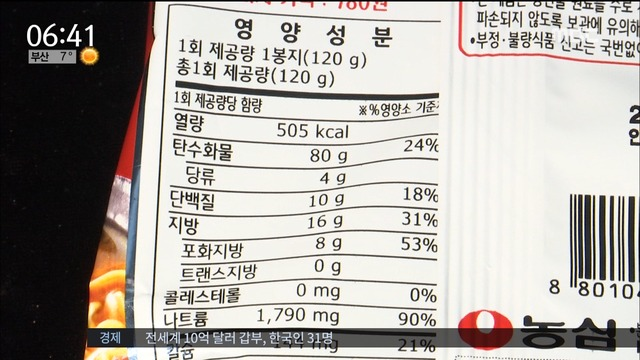

오늘 하루동안 드신 음식을 입력하세요. 입력 옵션은 세가지입니다.
1. 사진으로 입력하기
2. 영양성분표로 입력하기
3. 텍스트로 입력하기
4. 입력 종료
3
오늘 하루동안 드신 음식의 이름을 영어로 입력해주세요.
음식명 : jelly
몇인분 드셨나요? 소수점으로 입력해주세요. (1인분 : 1) 1
searched food name:  Jelly (All Flavors) , calorie:  51
오늘 하루동안 드신 음식을 입력하세요. 입력 옵션은 세가지입니다.
1. 사진으로 입력하기
2. 영양성분표로 입력하기
3. 텍스트로 입력하기
4. 입력 종료
3
오늘 하루동안 드신 음식의 이름을 영어로 입력해주세요.
음식명 : donut
몇인분 드셨나요? 소수점으로 입력해주세요. (1인분 : 1) 1
searched food name:  Sugared or Glazed Doughnuts  , calorie:  192
오늘 하루동안 드신 음식을 입력하세요. 입력 옵션은 세가지입니다.
1. 사진으로 입력하기
2. 영양성분표로 입력하기
3. 텍스트로 입력하기
4. 입력 종료
3
오늘 하루동안 드신 음식의 이름을 영어로 입력해주세요.
음식명 : milk
몇인분 드셨나요? 소수점으로 입력해주세요. (1인분 : 1) 1
searched food name:  Whole Milk , calorie:  146
오늘 하루동안 드신 음식을 입력하세요. 입력 옵션은 세가지입니다.
1. 사진으로 입력하기
2. 영양성분표로 입력하기
3. 텍스트로 입력하기
4. 입력 종료
4


In [ ]:
# 입력값 받기
print("******* USER CALORIE CALCULATOR *******")
name = input("이름을 입력하세요:  ")
print(name,"님의 신체정보를 입력하세요")
age = int(input("나이를 입력하세요 (세): "))
height = float(input("신장을 입력하세요 (cm): "))
weight = float(input("체중을 입력하세요 (kg): "))
gender = input("성별을 입력하세요 (남성 또는 여성): ")
heart_rate = float(input("심박수를 입력하세요 : "))
body_temp = float(input("체온을 입력하세요 (℃): "))
print("******************")
exec_flag = input("운동을 하셨나요? (y/n)")
if exec_flag == "y" or "Y" or "yes":
  exec = input("운동 종류를 입력하세요: ")
  duration = float(input("운동 시간을 입력하세요 (분): "))
  user_exec = {
      "Exercise" : exec,
      "Duration" : duration,
      "Weight": weight
  }
else :
  exec = '\0'
  duration = 0
print("******************")
while 1:
  opt = int(input("오늘 하루동안 드신 음식을 입력하세요. 입력 옵션은 세가지입니다.\n1. 사진으로 입력하기\n2. 영양성분표로 입력하기\n3. 텍스트로 입력하기\n4. 입력 종료\n"))
  if opt == 1:
    # 사진으로 입력하기
    food_quantity = float(input("몇인분 드셨나요? 소수점으로 입력해주세요. (1인분 : 1) "))
    img_path = '/content/drive/MyDrive/calories/sample_images/foods/applepie.jpg'
    food_name = image_to_foodname(img_path)
    s_food_name, calorie = crawling_calorie(food_name)
    if calorie == -1:
      print("Name_to_link processing is failed")
    elif calorie == -2:
      print("Calorie info not found")
    else:
      print('searched food name: ', s_food_name, ', calorie: ', calorie)
      user_food[s_food_name] = { "amount" : food_quantity, "calories" : calorie }


  elif opt == 2:
    # 영양성분표 입력하기
    food_quantity = float(input("몇인분 드셨나요? 소수점으로 입력해주세요. (1인분 : 1) "))
    image_path = '/content/drive/MyDrive/calories/sample_images/nutrition_fact/nutrition_fact_3.jpg'
    appkey = '300d2dd3bf796bae20533ff9d4c975f3'

    output = get_orc_json(image_path, appkey)
    kcal_val = find_kcal_in_output(output, image_path)

    if(kcal_val == ""):
      print("kcal value is not found")
    else:
      print("kcal value is ", kcal_val)
      get_image(image_path)
      food_name = 'Ramen'
      user_food[food_name] = { "amount" : food_quantity, "calories" : kcal_val }

  elif opt == 3:
    print("오늘 하루동안 드신 음식의 이름을 영어로 입력해주세요.")
    food_name = input("음식명 : ")
    food_quantity = float(input("몇인분 드셨나요? 소수점으로 입력해주세요. (1인분 : 1) "))
    s_food_name, calorie = crawling_calorie(food_name)
    if calorie == -1:
      print("Name_to_link processing is failed")
    elif calorie == -2:
      print("Calorie info not found")
    else:
      print('searched food name: ', s_food_name, ', calorie: ', calorie)
      user_food[s_food_name] = { "amount" : food_quantity, "calories" : calorie }

  elif opt == 4:
    break

# 성별 numerical 값으로 변환하기 : 여성이면 1, 남성이면 0
gender_num = 0
if gender == "여성":
    gender_num = 1

# 결과 딕셔너리로 저장
user_info = {
    "Age": float(age),
    "Height": height,
    "Weight": weight,
    "Duration" : duration,
    "Heart_Rate" : heart_rate,
    "Body_Temp" : body_temp,
    "Gender": float(gender_num)
}

# 결과 출력
#print("입력받은 값:")
#for key, value in user_info.items():
#    print(key + ":", value)

## 기초대사량, 활동대사량 계산
(1) BMR(기초대사량) + 활동대사량</br>
(2) TDEE = BMR(기초대사량) * 활동계수(1.2~1.9)

#### BMR 계산
해리스-베네딕트 공식 이용
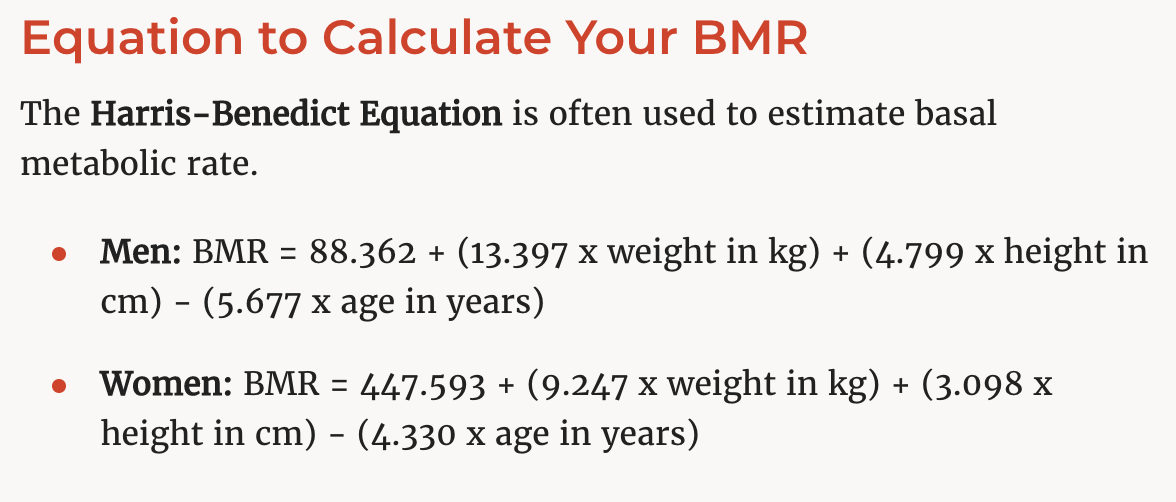

In [ ]:
def calculate_bmr_HB(person):
    if person['Gender'] == 1:  # 남성
        bmr = 66 + (13.7 * person['Weight']) + (5 * person['Height']) - (6.8 * person['Age'])
    else:  # 여성
        bmr = 655 + (9.6 * person['Weight']) + (1.8 * person['Height']) - (4.7 * person['Age'])
    return bmr

In [ ]:
user_bmr_HB = calculate_bmr_HB(user_info)
print(user_bmr_HB)

1425.9


### 1. BMR + 회귀예측
BMR(기초대사량)과 회귀예측으로 구한 활동대사량을 각각 구해 더함.

In [ ]:
user_info_df = pd.DataFrame(user_info, index=[0])
user_info_df[numerical_cols] = minmax_scaler.transform(user_info_df[numerical_cols])
print(user_info_df)

        Age    Height    Weight  Duration  Heart_Rate  Body_Temp  Gender
0  0.050847  0.565657  0.229167  1.413793    0.213115      -0.25     0.0


In [ ]:
user_poly = polynomial_features.transform(user_info_df)
user_active_calorie = model_reg.predict(user_poly)[0]
print(user_active_calorie)

152.55815254095472


In [ ]:
user_bmr_reg = user_active_calorie + user_bmr_HB
print(user_bmr_reg)

1578.4581525409549


#### 활동대사량 구하기 : 입력값으로 회귀 예측

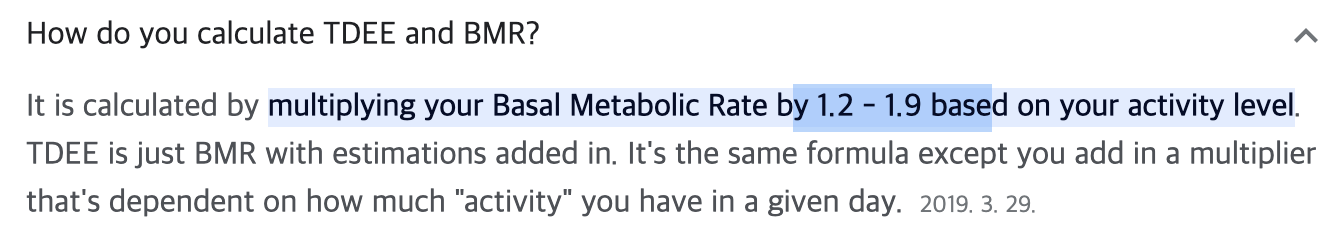

### 2. TDEE (use active coefficient)
BMR(기초대사량)에 회귀예측한 값을 5등분한 활동계수를 곱하는 방식. 기초대사량과 활동대사량을 모두 포함.</br>
클래스를 5개로 나누는 과정은 운동별 칼로리 소모량의 Kcal당 칼로리 소모 정보를 가지고 군집화함.</br>
회귀예측한 활동대사량을 다시 운동시간과 몸무게로 나누어서 kcal당 활동대사량을 도출한 후, 군집화 모델에 넣어 활동계수 도출</br>

#### 외부 데이터 불러오기

In [ ]:
c_info = pd.read_csv('/content/drive/MyDrive/calories/운동에 따른 칼로리 소모량.csv')
print(c_info)

        Activity, Exercise or Sport (1 hour)  130 lb  155 lb  180 lb  205 lb  \
0                Cycling, mountain bike, bmx     502     598     695     791   
1        Cycling, <10 mph, leisure bicycling     236     281     327     372   
2                   Cycling, >20 mph, racing     944    1126    1308    1489   
3                Cycling, 10-11.9 mph, light     354     422     490     558   
4             Cycling, 12-13.9 mph, moderate     472     563     654     745   
..                                       ...     ...     ...     ...     ...   
243                         General cleaning     207     246     286     326   
244                        Cleaning, dusting     148     176     204     233   
245                         Taking out trash     177     211     245     279   
246            Walking, pushing a wheelchair     236     281     327     372   
247  Teach physical education,exercise class     236     281     327     372   

     Calories per kg  
0           1.75

In [ ]:
xcol = ['130 lb', '155 lb', '180 lb', '205 lb']
c_info.drop(columns = xcol, axis = 1, inplace = True)

c_info = c_info.set_index('Activity, Exercise or Sport (1 hour)')

# c_info = c_info.transpose()

기존의 운동별 칼로리 소모량 데이터에서는 feature가 다음과 같았다.</br> 계산하기 위해서 다른 feature는 drop시키고 'calories per kg'만 이용했다.</br> 130lb(58kg) 값이 kg당 칼로리를 이용해서 계산이 제대로 나오지 않아서, 같은 데이터셋을 활용한 포럼글을 참고해 보정해주는 보정 수치를 구했다.
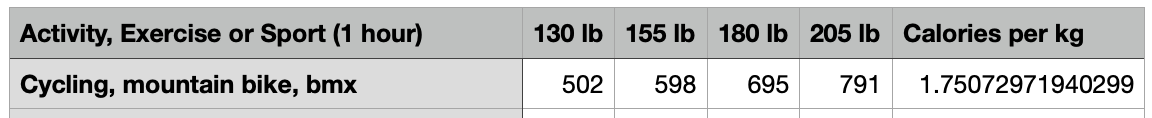

**kg당 칼로리를 직접 구한 결과와 Calories per kg이 다르다는 것을 확인할 수 있다.**</br>
130lb -> 58.97kg, 502/58.97 = 8.512</br>
155lb -> 70.31kg, 598/70.31 = 8.5</br>
180lb -> 81.65kg, 695/81.65 = 8.511</br>
205lb -> 92.99kg, 791/92.99 = 8.50</br>

In [ ]:
# 데이터 오차 계산

# for index, row in c_info.iterrows():
#     result = row['205 lb'] / 205 * 0.45359237 - row['Calories per kg']
#     error = abs(result) / row['Calories per kg'] * 100
#     if error >= 0.2:
#         print(f"Result: {result}, Error: {error}%")

In [ ]:
c_info['Calories per kg'] = c_info['Calories per kg'] / 0.45359237 / 0.45359237
print(c_info)

                                         Calories per kg
Activity, Exercise or Sport (1 hour)                    
Cycling, mountain bike, bmx                     8.509178
Cycling, <10 mph, leisure bicycling             4.001222
Cycling, >20 mph, racing                       16.014761
Cycling, 10-11.9 mph, light                     6.001833
Cycling, 12-13.9 mph, moderate                  8.009025
...                                                  ...
General cleaning                                3.504360
Cleaning, dusting                               2.504054
Taking out trash                                3.000917
Walking, pushing a wheelchair                   4.001222
Teach physical education,exercise class         4.001222

[248 rows x 1 columns]


#### 군집화
운동별 칼로리 소모량을 5개의 클래스로 나누어 활동계수 할당
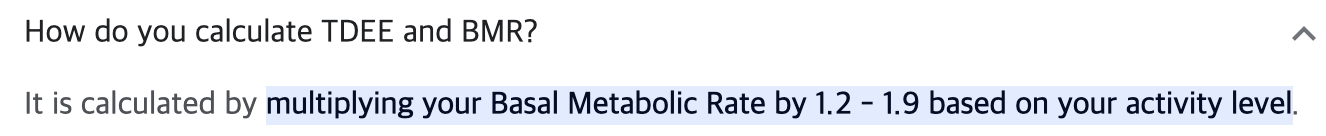

In [ ]:
from sklearn.cluster import KMeans

def cluster_calories(data, num_clusters):
    # 'Calories per kg' 열의 값만 추출하여 군집화 수행
    calories = data['Calories per kg'].values.reshape(-1, 1)

    # K-means 알고리즘을 사용하여 군집화
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(calories)

    # 군집화 결과를 데이터프레임에 추가
    data['Cluster'] = kmeans.labels_

    return data

# 예시: calories 데이터를 5개 군집으로 분류
num_clusters = 5
clustered_data = cluster_calories(c_info, num_clusters)

# 군집화 결과 확인
print(clustered_data)

                                         Calories per kg  Cluster
Activity, Exercise or Sport (1 hour)                             
Cycling, mountain bike, bmx                     8.509178        2
Cycling, <10 mph, leisure bicycling             4.001222        0
Cycling, >20 mph, racing                       16.014761        3
Cycling, 10-11.9 mph, light                     6.001833        4
Cycling, 12-13.9 mph, moderate                  8.009025        2
...                                                  ...      ...
General cleaning                                3.504360        0
Cleaning, dusting                               2.504054        0
Taking out trash                                3.000917        0
Walking, pushing a wheelchair                   4.001222        0
Teach physical education,exercise class         4.001222        0

[248 rows x 2 columns]


In [ ]:
def update_cluster_order(data):
    # 군집별 최솟값을 기준으로 순서 변경
    min_values = data.groupby('Cluster')['Calories per kg'].min().sort_values()
    new_order = {cluster: index for index, cluster in enumerate(min_values.index)}
    updated_cluster_labels = data['Cluster'].map(new_order)

    # 데이터프레임에 업데이트된 군집 번호 열 추가
    updated_data = data.copy()
    updated_data['Cluster'] = updated_cluster_labels

    return updated_data

# 군집화된 데이터의 군집 번호를 최솟값에 따라 순서 변경하여 데이터프레임으로 반환
clustered_data = update_cluster_order(clustered_data)

# 업데이트된 데이터프레임 출력
print(clustered_data)

                                         Calories per kg  Cluster
Activity, Exercise or Sport (1 hour)                             
Cycling, mountain bike, bmx                     8.509178        2
Cycling, <10 mph, leisure bicycling             4.001222        0
Cycling, >20 mph, racing                       16.014761        4
Cycling, 10-11.9 mph, light                     6.001833        1
Cycling, 12-13.9 mph, moderate                  8.009025        2
...                                                  ...      ...
General cleaning                                3.504360        0
Cleaning, dusting                               2.504054        0
Taking out trash                                3.000917        0
Walking, pushing a wheelchair                   4.001222        0
Teach physical education,exercise class         4.001222        0

[248 rows x 2 columns]


In [ ]:
def print_cluster_min_max(data):
    # 각 군집별 최솟값과 최댓값 출력
    for cluster_id in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster_id]
        min_value = cluster_data['Calories per kg'].min()
        max_value = cluster_data['Calories per kg'].max()
        num_instances = cluster_data.shape[0]
        print(f"Cluster {cluster_id}: Min = {min_value}, Max = {max_value}, Count = {num_instances}")

# 군집화된 데이터에서 최솟값과 최댓값 출력
print_cluster_min_max(clustered_data)

Cluster 0: Min = 1.5070393092089251, Max = 4.303946324116321, Count = 82
Cluster 1: Min = 4.507956012262508, Max = 6.505276668790507, Count = 54
Cluster 2: Min = 7.005429452632755, Max = 9.006040588001794, Count = 66
Cluster 3: Min = 10.009636634527432, Max = 12.51369103257981, Count = 35
Cluster 4: Min = 13.510706121423262, Max = 18.01537165484468, Count = 11


In [ ]:
calorie_per_hour = (user_active_calorie / user_exec['Duration'] * 60) / user_info['Weight']
print(calorie_per_hour)

3.7575899640629244


In [ ]:
def classify_cluster(input_value, data):
    # 각 군집의 최솟값과 최댓값 확인
    cluster_min_max = {}
    for cluster_id in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster_id]
        min_value = cluster_data['Calories per kg'].min()
        max_value = cluster_data['Calories per kg'].max()
        cluster_min_max[cluster_id] = (min_value, max_value)

    # 입력값이 어느 군집에 속하는지 확인
    for cluster_id, (min_value, max_value) in cluster_min_max.items():
        if input_value >= min_value and input_value <= max_value:
            return cluster_id

    return None

cluster = classify_cluster(calorie_per_hour,clustered_data)

# 군집화 끝

In [ ]:
def get_calorie_coeff(cluster) :
  if cluster == 0 :
    return 1.2
  elif cluster == 1:
    return 1.375
  elif cluster == 2:
    return 1.55
  elif cluster == 3:
    return 1.725
  else :
    return 1.9

In [ ]:
calorie_class = get_calorie_coeff(cluster)

# 결과 출력
print(calorie_class)

1.2


#### 외부데이터로 활동대사량 계산

In [ ]:
c_info = c_info.transpose()
print(c_info.head())

Activity, Exercise or Sport (1 hour)  Cycling, mountain bike, bmx  \
Calories per kg                                          8.509178   
Cluster                                                  2.000000   

Activity, Exercise or Sport (1 hour)  Cycling, <10 mph, leisure bicycling  \
Calories per kg                                                  4.001222   
Cluster                                                          0.000000   

Activity, Exercise or Sport (1 hour)  Cycling, >20 mph, racing  \
Calories per kg                                      16.014761   
Cluster                                               3.000000   

Activity, Exercise or Sport (1 hour)  Cycling, 10-11.9 mph, light  \
Calories per kg                                          6.001833   
Cluster                                                  4.000000   

Activity, Exercise or Sport (1 hour)  Cycling, 12-13.9 mph, moderate  \
Calories per kg                                             8.009025   
Cluster  

## 섭취 칼로리 계산


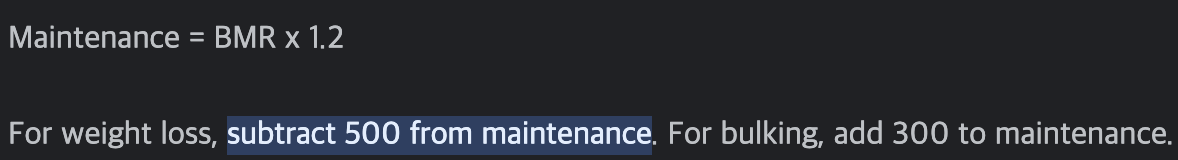

In [1]:
maintenance = user_bmr_HB * 1.2
lose_weight = maintenance - 500
bulk_weight = maintenance + 300

NameError: name 'user_bmr_HB' is not defined

In [ ]:
intake_calories = 0

for food in user_food:
    amount = user_food[food]["amount"]
    calories = user_food[food]["calories"]
    amount_calories = amount * float(calories)
    user_food[food]["amount_calories"] = amount_calories
    print(food, amount,"인분 :", amount_calories)
    intake_calories += amount_calories

print("총 섭취 칼로리는", intake_calories, "입니다")

## OUTPUT

In [ ]:
# 운동해서 소모한 추가적인 칼로리 소모량
out_data_calorie = c_info.loc['Calories per kg',user_exec['Exercise']] * user_info['Weight'] / 60 * user_info['Duration']

In [ ]:
print("***************************************")
print(name, "님의 칼로리 정보를 알려드리겠습니다.")
print("하루 전체 칼로리 소모량은 기초대사량과 활동대사량으로 나타납니다.", name, "님의 기초, 활동대사량은 다음과 같습니다.\n")
print("- harris benedict 방식은 BMR(기초대사량)을 구하고 활동대사량을 회귀예측한 값을 덧셈한 값입니다.")
print("Harris-Benedict : ",user_bmr_reg + out_data_calorie)
print("\n")
print("- TDEE 방식은 harris benedict방식으로 구한 BMR(기초대사량)에 운동별 칼로리 소모량 데이터를 기준으로 5개의 단계로 나누어 활동계수를 지정해 곱한 값입니다.")
print("TDEE : ",user_bmr_HB * calorie_class + out_data_calorie)
print("\n전체 칼로리 소모량 중", out_data_calorie, "는", name, "님의 운동을 통한 추가적인 칼로리 소모량입니다.")
print("\n***************************************")
print(name, "님의 일일 칼로리 섭취량은 다음과 같습니다.")

intake_calories = 0

for food in user_food:
    amount = user_food[food]["amount"]
    calories = user_food[food]["calories"]
    amount_calories = amount * float(calories)
    user_food[food]["amount_calories"] = amount_calories
    print(food, amount,"인분 :", amount_calories)
    intake_calories += amount_calories

print("총 섭취 칼로리는", int(intake_calories), "입니다")

print("\n***************************************")
print(name, "님의 칼로리 정보를 토대로 칼로리 섭취량에 대한 피드백을 해드리겠습니다.")
print("1. 체중 감소를 원하는 경우\n2. 체중 증량을 원하는 경우\n3. 체중 유지를 원하는 경우")
option = int(input())

if option == 1:
  print("체중 감소를 원하시는", name, "님의 신체 정보와 칼로리 정보를 바탕으로 계산한 적정 칼로리 섭취량입니다. :", int(lose_weight))
  if lose_weight - intake_calories > 0 :
    print("오늘 섭취한 칼로리는 총", int(intake_calories), "입니다. 과한 식단 조절을 피하고", int(lose_weight - intake_calories), "kcal 만큼 추가 섭취하시길 권장드립니다.")
  else:
    print("오늘 섭취한 칼로리는 총", int(intake_calories), "입니다.", int(intake_calories - lose_weight), "kcal를 적정 칼로리 대비 추가 섭취하셨습니다.")

if option == 2:
  print("체중 증량을 원하시는", name, "님의 신체 정보와 칼로리 정보를 바탕으로 계산한 적정 칼로리 섭취량입니다. :", int(bulk_weight))
  if bulk_weight - intake_calories > 0 :
    print("오늘 섭취한 칼로리는 총", int(intake_calories), "입니다.", int(bulk_weight - intake_calories), "kcal 만큼 추가 섭취하시길 권장드립니다.")
  else:
    print("오늘 섭취한 칼로리는 총", int(intake_calories), "입니다.", int(intake_calories - bulk_weight), "kcal를 적정 칼로리 대비 추가 섭취하셨습니다.")

else:
  print(name, "님의 적정 칼로리 섭취량은 ", int(maintenance), "입니다. 균형 잡힌 식사와 운동을 생활화하시길 바랍니다.")

***************************************
홍길동 님의 칼로리 정보를 알려드리겠습니다.
하루 전체 칼로리 소모량은 기초대사량과 활동대사량으로 나타납니다. 홍길동 님의 기초, 활동대사량은 다음과 같습니다.

- harris benedict 방식은 BMR(기초대사량)을 구하고 활동대사량을 회귀예측한 값을 덧셈한 값입니다.
Harris-Benedict :  1761.4811666388127


- TDEE 방식은 harris benedict방식으로 구한 BMR(기초대사량)에 운동별 칼로리 소모량 데이터를 기준으로 5개의 단계로 나누어 활동계수를 지정해 곱한 값입니다.
TDEE :  1894.103014097858

전체 칼로리 소모량 중 183.02301409785784 는 홍길동 님의 운동을 통한 추가적인 칼로리 소모량입니다.

***************************************
홍길동 님의 일일 칼로리 섭취량은 다음과 같습니다.
Apple Pie 1.0 인분 : 410.0
Ramen 1.0 인분 : 505.0
Jelly (All Flavors) 1.0 인분 : 51.0
Sugared or Glazed Doughnuts  1.0 인분 : 192.0
Whole Milk 1.0 인분 : 146.0
총 섭취 칼로리는 1304 입니다

***************************************
홍길동 님의 칼로리 정보를 토대로 칼로리 섭취량에 대한 피드백을 해드리겠습니다.
1. 체중 감소를 원하는 경우
2. 체중 증량을 원하는 경우
3. 체중 유지를 원하는 경우
1
체중 감소를 원하시는 홍길동 님의 신체 정보와 칼로리 정보를 바탕으로 계산한 적정 칼로리 섭취량입니다. : 1211
오늘 섭취한 칼로리는 총 1304 입니다. 92 kcal를 적정 칼로리 대비 추가 섭취하셨습니다.
홍길동 님의 적정 칼로리 섭취량은  1711 입니다. 균형 잡힌 식사와 운동을 생활화하시길 바랍니다.
